In [94]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
from struct import unpack
import os
import shutil

In [2]:
## images path
orig_path = pathlib.Path(r'C:\Users\istra\img\images\images')
destin_path= pathlib.Path(r'C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final')
image_count=len(list(orig_path.glob('*.jpg')))
print(image_count)

53618


-------------------------------
Opening the csv file

In [3]:
goodread = pd.read_csv(r'C:\Users\istra\img\book_data.csv')

-----------------
Splitting the genres column

In [4]:
all_genres = [ str(genres).split("|") for genres in goodread["genres"]]

In [5]:
all_genres_long =pd.DataFrame([genre for book in all_genres for genre in book])

In [7]:
all_genres_long.columns = ("genre",)

Plotting the main genres we see in all tags > 800

<AxesSubplot:xlabel='genre'>

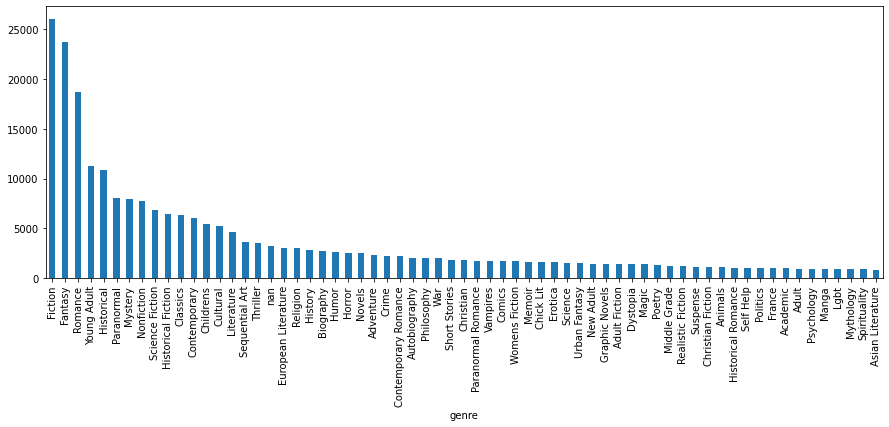

In [8]:
all_genres_long.value_counts("genre")[all_genres_long.value_counts("genre")>800 ].plot.bar(figsize=(15,5))

In [9]:
pd.DataFrame(all_genres_long.value_counts("genre")[all_genres_long.value_counts("genre")>800 ])

,0
genre,
Fiction,26007
Fantasy,23722
Romance,18732
Young Adult,11320
Historical,10868
...,...
Manga,927
Lgbt,903
Mythology,891


---------------------
Analysis of the genres in Nonfiction

In [10]:
listna =goodread["genres"].str.contains('Nonfiction')
listna[listna.isna()] = False
nonfiction_books = goodread[listna]

<AxesSubplot:xlabel='0'>

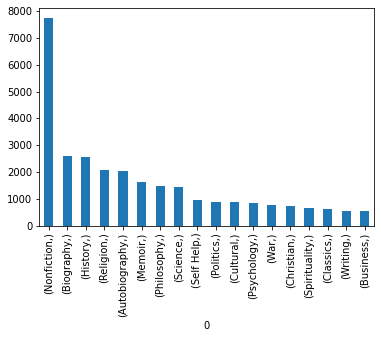

In [11]:
nonfiction = pd.DataFrame(all_genres)[listna]
l=[]
i=0
while i<len(nonfiction):
    j=0
    while j<17:
        l.append(nonfiction.iloc[i,j])
        j+=1
    i+=1
pd.DataFrame(l).value_counts()[pd.DataFrame(l).value_counts()>500].plot.bar()

Parmi non fiction on regroupe : 
 - Biography + Autobiography + Memoir
 - Philosophy + Spirituality + Religion + Christian 
 - History + Politics + War 

-------------------------------
Doing the same analysis for the first, second and thrid tag

In [12]:
genre_tags = pd.DataFrame(all_genres).iloc[:,0:3]
genre_tags.columns = ("first","second","third")

<AxesSubplot:xlabel='third'>

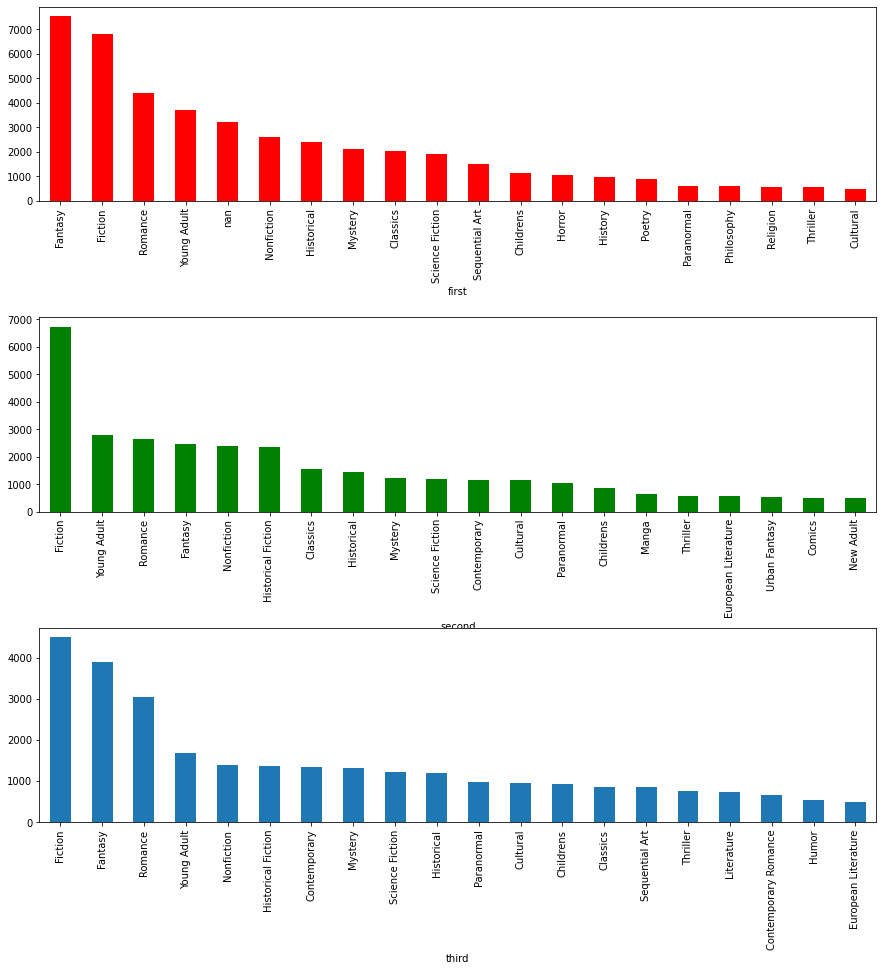

In [13]:
fig,axes  = plt.subplots(nrows = 3 , ncols =1, figsize=(15,15))
fig.subplots_adjust(hspace=0.6)
genre_tags.value_counts("first")[:20].plot.bar(ax=axes[0],color="red")
genre_tags.value_counts("second")[:20].plot.bar(ax=axes[1],color="green")
genre_tags.value_counts("third")[:20].plot.bar(ax=axes[2])

---------------------
Because there is a lot of overlapping between genres, mont books having multiple tags, we will take on the first tag that is from  the following categories : 

'Fantasy','Romance', 'Young Adult', 'Historical', 'Mystery', 'Science Fiction', 'Sequential Art', 'History', 'Childrens', 'Horror', 'Poetry', 'War','Politics','Christian','Spirituality','Religion','Philosophy','Memoir','Autobiography','Biography','Comics','Manga','Graphic Novels','Thriller','Historical Fiction','Crime'

In [14]:
glist = ['Fantasy','Romance', 'Young Adult', 'Historical', 'Mystery', 'Science Fiction', 'Sequential Art', 'History', 'Childrens', 'Horror', 'Poetry', 'War','Politics','Christian','Spirituality','Religion','Philosophy','Memoir','Autobiography','Biography','Comics','Manga','Graphic Novels','Thriller','Historical Fiction','Crime']

genres = pd.DataFrame([next((genre for genre in book if genre in glist),None) for book in all_genres],columns =("genre",))

All Books that are ommited from the analysis 

In [15]:
genres["genre"].isna().sum()

10453

In [16]:
final_genres = goodread.drop(goodread.loc[:,"book_edition":"book_review_count"].columns, axis=1).drop("image_url",axis=1)

In [17]:
final_genres["main_genre"] = genres
final_genres["img"] = final_genres.index.astype('str')+".jpg"

In [18]:
tags = pd.DataFrame(genres.value_counts("genre"), columns =("count",))
tags

,count
genre,
Fantasy,8717
Romance,6515
Young Adult,4536
Historical,4507
Mystery,2846
Science Fiction,2578
History,1702
Childrens,1686
Sequential Art,1582


<AxesSubplot:xlabel='genre'>

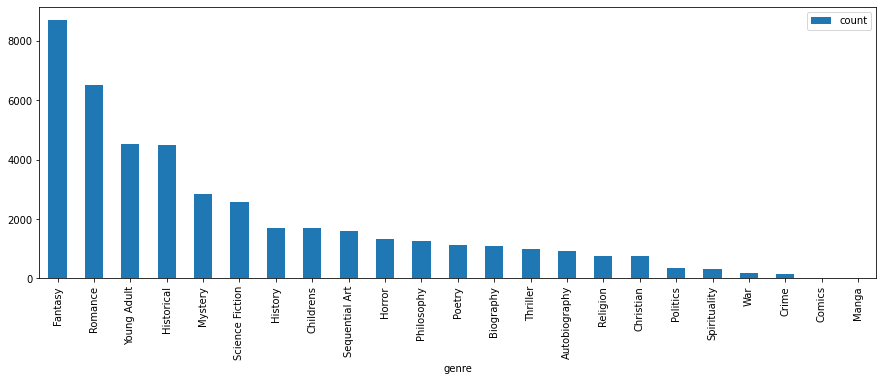

In [19]:
tags[tags["count"]>1].plot.bar(figsize=(15,5))

In [20]:
selected_categories = list(tags.index)
selected_categories

['Fantasy',
 'Romance',
 'Young Adult',
 'Historical',
 'Mystery',
 'Science Fiction',
 'History',
 'Childrens',
 'Sequential Art',
 'Horror',
 'Philosophy',
 'Poetry',
 'Biography',
 'Thriller',
 'Autobiography',
 'Religion',
 'Christian',
 'Politics',
 'Spirituality',
 'War',
 'Crime',
 'Comics',
 'Manga']

--------------------
Mapping function to regroup some genres 

In [21]:
def return_label(mg):
    if mg in selected_categories:
        val=mg
        if mg in ("Autobiography",'Biography','Memoir') : val = "Biography"
        if mg in ("Spirituality",'Christian','Religion','Philosophy') : val = "Religion & Philosophy"
        if mg in ("Politics",'War','History') : val = "Politics & History"
        if mg in ("Crime",'Thriller','Mystery') : val = "Mystery & Crime"
        if mg in ("Comics",'Manga','Sequential Art') : val = "Sequential Art"
    else:
        val = "Other"
    return val

In [22]:
final_genres_filtered = final_genres
final_genres_filtered["main_label"]=final_genres_filtered["main_genre"].map(return_label)
final_genres_filtered = final_genres_filtered[final_genres_filtered.main_label != "Other"]
final_genres_filtered = final_genres_filtered.drop("main_genre",axis=1)

<AxesSubplot:xlabel='main_label'>

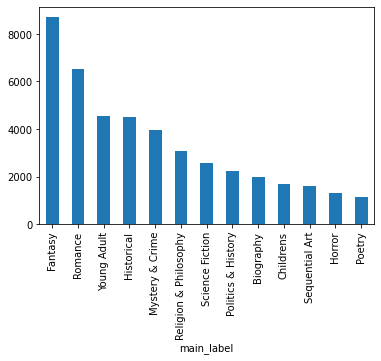

In [23]:
final_genres_filtered.value_counts("main_label").plot.bar()

In [24]:
len(final_genres_filtered)

43848

In [70]:
# removing book covers that were used in the survey
path_Q= pathlib.Path(r'C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\Q')
files = list(path_Q.glob('*.jpg'))
survey_images = [ str(f).rsplit("_")[-1] for f in files]
final_genres_filtered = final_genres_filtered[~final_genres_filtered["img"].isin(survey_images)]

In [71]:
ratios = final_genres_filtered.value_counts("main_label")/len(final_genres_filtered)
ratios

main_label
Fantasy                  0.198981
Romance                  0.148688
Young Adult              0.103488
Historical               0.102825
Mystery & Crime          0.090606
Religion & Philosophy    0.070004
Science Fiction          0.058767
Politics & History       0.050979
Biography                0.045543
Childrens                0.038394
Sequential Art           0.036293
Horror                   0.029920
Poetry                   0.025512
dtype: float64

In [72]:
len(final_genres_filtered)

43783

We are going to build a balanced train, validation and test sets :
- 32000 Train samples
- 8000 Validation Samples
- 3783 Test Sample + 65 books used for the survey

In [168]:
t=32000
v=8000
tst = 3783
train_nbr = round(ratios*t)
train_nbr[random.randrange(13)]+=(t-sum(train_nbr)) 

valid_nbr = round(ratios*v)
valid_nbr[random.randrange(13)]+=(v-sum(valid_nbr)) 

test_nbr = round(ratios*tst)
test_nbr[random.randrange(13)]+=(tst-sum(test_nbr)) 
sum(train_nbr+valid_nbr+test_nbr)

43783.0

Building balanced DataFrames , that respect the original dataset ratios

In [264]:
train_genres=[]
for index,gnbr in train_nbr.items():
    train_genres.append(final_genres_filtered[final_genres_filtered["main_label"]==index].sample(int(gnbr)))
df_train = pd.concat(train_genres)
df_train = df_train.sample(frac=1)

In [265]:
valid_genres=[]
for index,gnbr in valid_nbr.items():
    valid_genres.append(final_genres_filtered[((final_genres_filtered["main_label"]==index) & (~final_genres_filtered["img"].isin(df_train["img"])))].sample(int(gnbr)))
df_valid = pd.concat(valid_genres)
df_valid = df_valid.sample(frac=1)

In [266]:
#we check that dont have files in common between both datasets
len(set(df_valid.img).intersection(df_train.img))

0

In [267]:
# We check for duplicates
sum(df_valid.img.duplicated())

0

In [268]:
df_test =final_genres_filtered[(~final_genres_filtered["img"].isin(df_train["img"]))&(~final_genres_filtered["img"].isin(df_valid["img"]))]
len(df_test)

3783

In [271]:
len(set(df_test.img).intersection(df_train.img))

0

In [270]:
[len(df_train),len(df_valid),len(df_test)]

[32000, 8000, 3783]

In [272]:
# Small test that the ratios were kept : 
(df_train.value_counts("main_label")/len(df_train))-ratios

main_label
Fantasy                 -1.258979e-05
Romance                 -3.468812e-07
Young Adult              1.234497e-05
Historical              -1.279749e-05
Mystery & Crime         -1.219295e-05
Religion & Philosophy   -4.339584e-06
Science Fiction          1.414861e-05
Politics & History       5.255964e-05
Biography               -1.154058e-05
Childrens                1.235283e-05
Sequential Art          -1.137499e-05
Horror                  -1.403870e-05
Poetry                  -1.218509e-05
dtype: float64

In [263]:
%store final_genres_filtered

Stored 'final_genres_filtered' (DataFrame)


-------------------------
Check & Copy the selected files in sub-folders by genre

In [215]:
def check_image(fn):
    try:
        fobj = open(fn, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        if not is_jfif: raise NameError('corrupt file')
        file_contents = tf.io.read_file(fn)
        image = tf.image.decode_jpeg(file_contents, channels=3)
    except:
        print("check error",fn)
        raise NameError('corrupt file')

In [234]:
def copy_images(orig_path,destin_path,dataset):
    num_skipped = 0
    num_copied = 0 
    file_exists = 0
    corrupt_images=[]
    for index,book in dataset.iterrows():
        genre = book["main_label"]
        fpath = str(orig_path) +"\\"+book["img"]
        target= str(destin_path)+"\\"+genre+"\\"+book["img"]
        if not os.path.exists(str(destin_path)+"\\"+genre): 
            os.mkdir(str(destin_path)+"\\"+genre)
        try:
            if os.path.isfile(target):
                file_exists+=1
            else:
                check_image(fpath)
        except:
            print("error, the following image was not copied",fpath)
            corrupt_images.append(book["img"])
            num_skipped+=1
        else:
            try:
                if not os.path.isfile(target):
                    shutil.copy(fpath,target)
                    num_copied +=1

            except IOError as e:
                print("Unable to copy file. %s" % e)
            except:
                print("Unexpected error:", sys.exc_info())
    print("We skipped %d corrupt images" % num_skipped)
    print("There were already %d files there" %file_exists)
    print("We copied %d files" %num_copied)
    return corrupt_images

In [273]:
orig_path = pathlib.Path(r'C:\Users\istra\img\images\images')
train_path= pathlib.Path(r'C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\train')
## Copy train
corrupt_train_img = copy_images(orig_path,train_path,df_train)
#updating the dataframe to remove the corrupt images 
df_train = df_train[~df_train["img"].isin(corrupt_train_img)]
#saving to csv
df_train.to_csv("train.csv")

check error C:\Users\istra\img\images\images\13905.jpg
error, the following image was not copied C:\Users\istra\img\images\images\13905.jpg
check error C:\Users\istra\img\images\images\50995.jpg
error, the following image was not copied C:\Users\istra\img\images\images\50995.jpg
check error C:\Users\istra\img\images\images\53557.jpg
error, the following image was not copied C:\Users\istra\img\images\images\53557.jpg
check error C:\Users\istra\img\images\images\33835.jpg
error, the following image was not copied C:\Users\istra\img\images\images\33835.jpg
check error C:\Users\istra\img\images\images\34066.jpg
error, the following image was not copied C:\Users\istra\img\images\images\34066.jpg
check error C:\Users\istra\img\images\images\51687.jpg
error, the following image was not copied C:\Users\istra\img\images\images\51687.jpg
check error C:\Users\istra\img\images\images\33274.jpg
error, the following image was not copied C:\Users\istra\img\images\images\33274.jpg
check error C:\Users

In [274]:
valid_path= pathlib.Path(r'C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\valid')
## Copy valid
corrupt_valid_img = copy_images(orig_path,valid_path,df_valid)
#updating the dataframe to remove the corrupt images 
df_valid = df_valid[~df_valid["img"].isin(corrupt_valid_img)]
#saving to csv
df_valid.to_csv("valid.csv")

check error C:\Users\istra\img\images\images\48295.jpg
error, the following image was not copied C:\Users\istra\img\images\images\48295.jpg
check error C:\Users\istra\img\images\images\22268.jpg
error, the following image was not copied C:\Users\istra\img\images\images\22268.jpg
check error C:\Users\istra\img\images\images\48789.jpg
error, the following image was not copied C:\Users\istra\img\images\images\48789.jpg
check error C:\Users\istra\img\images\images\50954.jpg
error, the following image was not copied C:\Users\istra\img\images\images\50954.jpg
check error C:\Users\istra\img\images\images\51974.jpg
error, the following image was not copied C:\Users\istra\img\images\images\51974.jpg
check error C:\Users\istra\img\images\images\47160.jpg
error, the following image was not copied C:\Users\istra\img\images\images\47160.jpg
check error C:\Users\istra\img\images\images\42125.jpg
error, the following image was not copied C:\Users\istra\img\images\images\42125.jpg
check error C:\Users

In [275]:
test_path= pathlib.Path(r'C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\test')
## Copy valid
corrupt_test_img = copy_images(orig_path,test_path,df_test)
#updating the dataframe to remove the corrupt images 
df_test = df_test[~df_test["img"].isin(corrupt_test_img)]
#saving to csv
df_test.to_csv("test.csv")

check error C:\Users\istra\img\images\images\17612.jpg
error, the following image was not copied C:\Users\istra\img\images\images\17612.jpg
check error C:\Users\istra\img\images\images\21972.jpg
error, the following image was not copied C:\Users\istra\img\images\images\21972.jpg
check error C:\Users\istra\img\images\images\22792.jpg
error, the following image was not copied C:\Users\istra\img\images\images\22792.jpg
check error C:\Users\istra\img\images\images\23490.jpg
error, the following image was not copied C:\Users\istra\img\images\images\23490.jpg
check error C:\Users\istra\img\images\images\25231.jpg
error, the following image was not copied C:\Users\istra\img\images\images\25231.jpg
check error C:\Users\istra\img\images\images\25786.jpg
error, the following image was not copied C:\Users\istra\img\images\images\25786.jpg
check error C:\Users\istra\img\images\images\26984.jpg
error, the following image was not copied C:\Users\istra\img\images\images\26984.jpg
check error C:\Users

In [276]:
# in total number of files 
len(df_train)+len(df_valid)+len(df_test)

43325